# French Motor Claims Datasets

This analysis uses the same features as in the book "Computational Actuarial Science with R" by Arthur Charpentier.

Charpentier Arthur and Katrien Antonio. 2015. Computational Actuarial Science with R. Boca Raton Florida: CRC Press.

In [1]:
import pandas as pd
import tarfile
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from stabletrees import BaseLineTree,AbuTreeI,NaiveUpdate,TreeReevaluation,StabilityRegularization, BootstrapUpdate
from sklearn.datasets import fetch_openml
SEED = 0
plt.rcParams["figure.figsize"] = (20,12)

In [2]:
df = fetch_openml(data_id=41214, as_frame=True).frame
df.head()

KeyboardInterrupt: 

Average Frequency = 0.10070308464041304
Fraction of exposure with zero claims = 93.9%


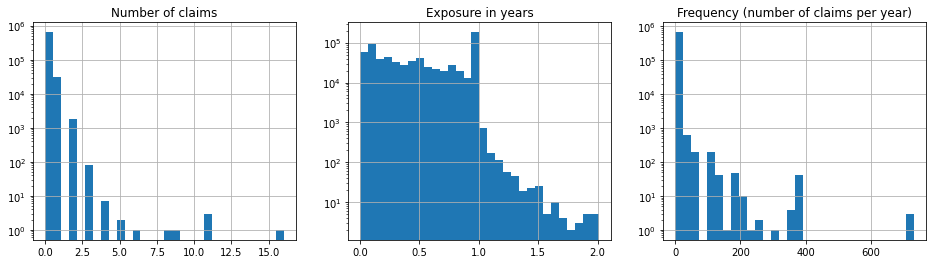

In [3]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

print(
    "Average Frequency = {}".format(np.average(df["Frequency"], weights=df["Exposure"]))
)

print(
    "Fraction of exposure with zero claims = {0:.1%}".format(
        df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()
    )
)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("Number of claims")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder


tree_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OrdinalEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("numeric", "passthrough", ["VehAge", "DrivAge", "BonusMalus", "Density"]),
    ],
    remainder="drop",
)

In [5]:
X = tree_preprocessor.fit_transform(df.drop("Frequency",axis=1))
y = df.Frequency.to_numpy()

In [18]:
t = BaseLineTree(criterion="poisson",adaptive_complexity=True).fit(X,y)
mean_poisson_deviance(y,t.predict(X)+0.001,sample_weight=df["Exposure"])

0.6750537180383467

In [16]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print(
        "MSE: %.3f"
        % mean_squared_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )
    print(
        "mean poisson deviance: %.3f"
        % mean_poisson_deviance(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )
    
tree_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OrdinalEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("numeric", "passthrough", ["VehAge", "DrivAge", "BonusMalus", "Density"]),
    ],
    remainder="drop",
)
poisson_gbrt = Pipeline(
    [
        ("preprocessor", tree_preprocessor),
        (
            "regressor",
            HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=128),
        ),
    ]
)
poisson_gbrt.fit(
    df, df["Frequency"], regressor__sample_weight=df["Exposure"]
)
score_estimator(poisson_gbrt, df)

MSE: 0.537
MAE: 0.180
mean poisson deviance: 0.548


In [17]:

from sklearn.tree import DecisionTreeRegressor
t = DecisionTreeRegressor(criterion="poisson",max_depth=20,min_samples_leaf=10).fit(X,y)
mean_poisson_deviance(y,t.predict(X)+0.001,sample_weight=df["Exposure"])


0.7009944269456511

In [9]:
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold
EPSILON = 1.1

def S1(pred1, pred2):
    return np.std(np.log((pred2+EPSILON)/(pred1+EPSILON)))

def S2(pred1, pred2):
    return np.mean((pred1- pred2)**2)

In [8]:
models = {  
            "baseline": BaseLineTree(),
            "NU": NaiveUpdate(),
            "TR":TreeReevaluation(delta=0.1),
            "SR":StabilityRegularization(),
            #"BT": BootstrapUpdate(),
            "ABU":AbuTreeI()
            }
stability_all = {name:[] for name in models.keys()}
standard_stability_all= {name:[] for name in models.keys()}
mse_all= {name:[] for name in models.keys()}

stability = {name:[] for name in models.keys()}
standard_stability = {name:[] for name in models.keys()}
mse = {name:[] for name in models.keys()}
train_stability = {name:[] for name in models.keys()}
train_standard_stability = {name:[] for name in models.keys()}
train_mse = {name:[] for name in models.keys()}
orig_stability = {name:[] for name in models.keys()}
orig_standard_stability = {name:[] for name in models.keys()}
orig_mse = {name:[] for name in models.keys()}

kf = RepeatedKFold(n_splits= 5,n_repeats=10, random_state=SEED)
for train_index, test_index in kf.split(X):
    X_12, y_12 = X[train_index],y[train_index]
    X_test,y_test = X[test_index],y[test_index]
    X1,X2,y1,y2 =  train_test_split(X_12, y_12, test_size=0.5, random_state=SEED)
    # initial model 
    criterion = "poisson"
    models = {  
                "baseline": BaseLineTree(criterion = criterion, adaptive_complexity=True),
                "NU": NaiveUpdate(criterion = criterion, adaptive_complexity=True),
            "TR":TreeReevaluation(criterion = criterion, adaptive_complexity=True, delta=0.1),
            "SR":StabilityRegularization(criterion = criterion, adaptive_complexity=True,lmbda=0.75),
            #"BT": BootstrapUpdate(criterion = criterion, adaptive_complexity=True),
            "ABU":AbuTreeI(criterion = criterion, adaptive_complexity=True)

            }
    for name, model in models.items():
        model.fit(X1,y1)
        
        pred1 = model.predict(X_test)
        pred1_train = model.predict(X_12)
        pred1_orig= model.predict(X1)
        #print("before")
        model.update(X_12,y_12)
        #print("after")
        pred2 = model.predict(X_test)
        pred2_orig= model.predict(X1)
        pred2_train =  model.predict(X_12)

        orig_mse[name].append(mean_poisson_deviance(y1+0.00001,pred2_orig+0.00001))
        orig_stability[name].append(S1(pred1_orig,pred2_orig))
        orig_standard_stability[name].append(S2(pred1_orig,pred2_orig))

        train_mse[name].append(mean_poisson_deviance(y_12+0.00001,pred2_train+0.00001))
        train_stability[name].append(S1(pred1_train,pred2_train))
        train_standard_stability[name].append(S2(pred1_train,pred2_train))
        mse[name].append(mean_poisson_deviance(y_test+0.00001,pred2+0.00001))
        stability[name].append(S1(pred1,pred2))
        standard_stability[name].append(S2(pred1,pred2))
    
for name in models.keys():
    print("="*80)
    print(f"{name}")
    orig_mse_scale = np.mean(orig_mse["baseline"]); orig_S1_scale = np.mean(orig_stability["baseline"]); orig_S2_scale = np.mean(orig_standard_stability["baseline"]);
    train_mse_scale = np.mean(train_mse["baseline"]); train_S1_scale = np.mean(train_stability["baseline"]); train_S2_scale = np.mean(train_standard_stability["baseline"]);
    mse_scale = np.mean(mse["baseline"]); S1_scale = np.mean(stability["baseline"]); S2_scale = np.mean(standard_stability["baseline"]);
    
    print(f"orig - mse: {np.mean(orig_mse[name]):.3f} ({np.mean(orig_mse[name])/orig_mse_scale:.2f}), stability: {np.mean(orig_stability[name]):.3f} ({np.mean(orig_stability[name])/orig_S1_scale:.2f}), standard stability: {np.mean(orig_standard_stability[name]):.3f} ({np.mean(orig_standard_stability[name])/orig_S2_scale:.2f})")
    print(f"train - mse: {np.mean(train_mse[name]):.3f} ({np.mean(train_mse[name])/train_mse_scale:.2f}), stability: {np.mean(train_stability[name]):.3f} ({np.mean(train_stability[name])/train_S1_scale:.2f}), standard stability: {np.mean(train_standard_stability[name]):.3f} ({np.mean(train_standard_stability[name])/train_S2_scale:.2f})")
    print(f"test - mse: {np.mean(mse[name]):.3f} ({np.mean(mse[name])/mse_scale:.2f}), stability: {np.mean(stability[name]):.3f} ({np.mean(stability[name])/S1_scale:.2f}), standard stability: {np.mean(standard_stability[name]):.3f} ({np.mean(standard_stability[name])/S2_scale:.2f})")
    print("="*80)
    mse_all[name] += [score/mse_scale for score in mse[name]]
    stability_all[name] += [score/S1_scale for score in stability[name]]
    standard_stability_all[name] += [score/S2_scale for score in standard_stability[name]]
print()

baseline
orig - mse: 2.010 (1.00), stability: 0.073 (1.00), standard stability: 0.084 (1.00)
train - mse: 2.024 (1.00), stability: 0.074 (1.00), standard stability: 0.087 (1.00)
test - mse: 2.049 (1.00), stability: 0.073 (1.00), standard stability: 0.084 (1.00)
NU
orig - mse: 2.018 (1.00), stability: 0.020 (0.28), standard stability: 0.013 (0.16)
train - mse: 2.043 (1.01), stability: 0.021 (0.28), standard stability: 0.015 (0.17)
test - mse: 2.058 (1.00), stability: 0.021 (0.28), standard stability: 0.014 (0.16)
TR
orig - mse: 2.018 (1.00), stability: 0.020 (0.28), standard stability: 0.013 (0.16)
train - mse: 2.042 (1.01), stability: 0.021 (0.28), standard stability: 0.015 (0.17)
test - mse: 2.058 (1.00), stability: 0.021 (0.28), standard stability: 0.014 (0.16)
SR
orig - mse: 1.999 (0.99), stability: 0.064 (0.87), standard stability: 0.066 (0.79)
train - mse: 2.019 (1.00), stability: 0.064 (0.87), standard stability: 0.069 (0.79)
test - mse: 2.049 (1.00), stability: 0.064 (0.87), sta